In [34]:
import pandas as pd
from hkfold import HKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import bisect
import seaborn as sns
sns.set()
from keras.layers import PReLU
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise, Input
from keras.models import load_model
from sklearn import metrics

In [14]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

In [22]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df[df.z > 10]

In [53]:
# large-scale parameters, should be included
F1 = [
    'dewpoint', 'spec_hum', 'press', 'temp', 'air_dens', 
    'virtual_temp', 'rel_hum', 'rain', 'z', 'wind'
]

# fluxes, better if not included
F2 = [
    'H', 'LE',
]

# radiation, no idea but probably should not include
F3 = [
    'co2flux', 'soilheat', 'netrad'
]

# we must be desperate to use these to make it work
F4 = [
    'lval', 'zL', 'ustar'
]

features = F1 #+ F2 + F3 + F4

target = 'phi_m'

In [116]:
def to_unix_datetime(year, month, daym, hday):
    minute = 60 * (hday - int(hday))
    second = 60 * (minute - int(minute))
    
    dt = datetime.datetime(
        year=int(year), month=int(month), day=int(daym) + 1,
        hour=int(hday), minute=int(minute), second=int(second)
    )
    
    return dt
    return int(time.mktime(dt.timetuple()))  # no need for sub-second resolution


def compute_trend(df, column, interval=60*60):
    sorted_df = df.sort_values(['qqq', 'z'])
    index = sorted_df.iloc

    def find_record(dt, z, direction, boundary_dt):
        # find the row at level z with datetime closest to dt
        # search by moving in given direction (increase/decrease dt)
        # until dt is reached
        
        direction = int(direction / abs(direction))  # convert to +/- 1
        assert direction == 1 or direction == -1

        find = bisect.bisect_left if direction > 0 else bisect.bisect_right
        pos = left_pos = min(len(sorted_df) - 1, find(sorted_df.qqq.values, dt))

        while (pos < len(sorted_df) and
               index[pos].z != z and
               (index[pos].qqq - boundary_dt) * direction <= 0):

            pos += direction

        assert index[pos].z == z, 'no observation at the same level'
        return index[pos]

    def compute(row):
        sample_before = find_record(row.qqq - interval, row.z, 1, row.qqq)
        sample_after = find_record(row.qqq + interval, row.z, -1, row.qqq)

        dval = sample_after[column] - sample_before[column]
        dtime = sample_after.qqq - sample_before.qqq
        
        return dval / dtime

    return compute


compute_trends = False

df = df.assign(
    dtime=lambda df: df.apply(
        lambda row: to_unix_datetime(row.year, row.month, row.daym, row.hday),
        axis=1
    )
)

# NB: for some training samples, the trend is computed using some test samples
if compute_trends:
    if 'dtime' not in df.columns:
        df = df.assign(
            dtime=lambda df: df.apply(
                lambda row: to_unix_datetime(row.year, row.month, row.daym, row.hday),
                axis=1
            )
        )
        
    df = df.assign(**{
        '%s_trend' % col: lambda df: df.apply(compute_trend(df, col) , axis=1)
        for col in features if not col.endswith('_trend')
    }).compute()

    features = set(features + ['%s_trend' % f for f in features])

In [246]:
from collections import deque


def make_index(dtimes):
    index = []
    window = deque()
    for i, dt in enumerate(dtimes):
        window.append((i, dt))
        if abs(window[0][1] - window[-1][1]) > 3600:
            window.popleft()
        index.append(window[0][0])

    return np.array(index)


def compute_trend(df, columns):
    df = df.sort_values('qqq')
    for z in df.z.unique():  
        print(z)
        sorted_df = df[df.z == z]
        index_below = make_index(sorted_df.qqq.values)
        above_reversed = make_index(sorted_df.qqq.values[::-1])
        index_above = len(sorted_df) - above_reversed[::-1] - 1

        for col in columns:
            print(col)
            val_above = sorted_df.iloc[index_above][col].values
            val_below = sorted_df.iloc[index_below][col].values

            time_above = sorted_df.iloc[index_above].qqq.values
            time_below = sorted_df.iloc[index_below].qqq.values

            trend = 3600 * dval / dtime

            df.loc[df.z == z, col + '_trend'] = 3600 * dval / dtime
            df.loc[df.z == z, col + '_trend_1'] = sorted_df.index[index_above]
            df.loc[df.z == z, col + '_trend_2'] = sorted_df.index[index_above]

    return df

asd = compute_trend(df, ['H', 'temp'])

40.0
dewpoint
spec_hum
press
temp
air_dens
virtual_temp
rel_hum
rain
soil_temp
z
wind
H
LE
co2flux
soilheat
netrad
20.0
dewpoint
spec_hum
press
temp
air_dens
virtual_temp
rel_hum
rain
soil_temp
z
wind
H
LE
co2flux
soilheat
netrad


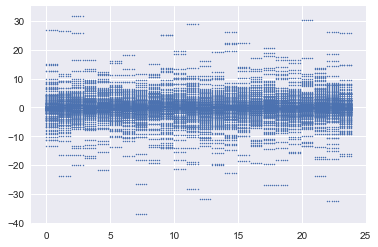

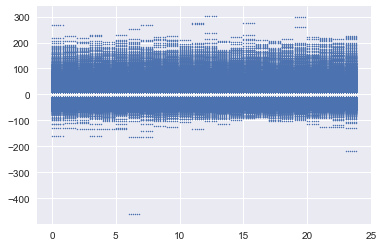

In [252]:
tt = asd[asd.year == 2005]
plt.scatter(tt.hday, tt.H_trend, s=1)
plt.show()
plt.scatter(df.hday, df.H, s=1)
plt.show()

In [54]:
test_ds = np.random.choice(df.ds.unique(), 12, replace=False)
test_mask = df.ds.isin(test_ds)
train_x, train_y = df[~test_mask][features], df[~test_mask][target]
test_x, test_y = df[test_mask][features], df[test_mask][target]
train_x, train_y = shuffle(train_x, train_y)

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 885564, testing with 55244


In [55]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [62]:
ll = model_input = Input(shape=(len(features),))
ll = PReLU()(Dense(1024)(ll))
ll = PReLU()(Dense(512)(ll))
ll = PReLU()(Dense(256)(ll))
ll = PReLU()(Dense(32)(ll))
ll = PReLU()(Dense(1)(ll))

opt = RMSprop(lr=0.001)
model = Model(inputs=model_input, outputs=ll)
model.compile(loss='mse', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              11264     
_________________________________________________________________
p_re_lu_50 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_51 (Dense)             (None, 512)               524800    
_________________________________________________________________
p_re_lu_51 (PReLU)           (None, 512)               512       
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
p_re_lu_52 (PReLU)           (None, 256)               256       
__________

In [63]:
hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=2048, epochs=250,
    shuffle=True,
    callbacks=[
        ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
        ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                        verbose=1, save_best_only=True),
        TensorBoard('dev/logs/', write_graph=False, write_grads=True),
        EarlyStopping(min_delta=0.0001, patience=30),
    ],
    validation_data=(norm_test_x, norm_test_y)
)

Train on 885564 samples, validate on 55244 samples
Epoch 1/250
880640/885564 [============================>.] - ETA: 0s - loss: 0.5218
Epoch 00001: val_loss improved from inf to 0.34700, saving model to dev/models/weights-w.0001-0.3470.hdf5
885564/885564 [==============================] - 10s 11us/step - loss: 0.5207 - val_loss: 0.3470
Epoch 2/250
880640/885564 [============================>.] - ETA: 0s - loss: 0.3589
Epoch 00002: val_loss did not improve
885564/885564 [==============================] - 9s 11us/step - loss: 0.3589 - val_loss: 0.3731
Epoch 3/250
880640/885564 [============================>.] - ETA: 0s - loss: 0.3309
Epoch 00003: val_loss improved from 0.34700 to 0.31975, saving model to dev/models/weights-w.0003-0.3197.hdf5
885564/885564 [==============================] - 10s 11us/step - loss: 0.3307 - val_loss: 0.3197
Epoch 4/250
880640/885564 [============================>.] - ETA: 0s - loss: 0.3178
Epoch 00004: val_loss did not improve
885564/885564 [================

KeyboardInterrupt: 

In [59]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

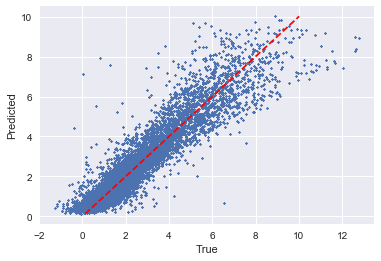

Explained variance 0.8711198015330996
Mean absolute error 0.43046116433517867
Mean squared error 0.43789031325265876
Median absolute error 0.28402285193515076
R2 score 0.8704058092112739
Mean absolute percent error [66.71847]


In [91]:
best_model = load_model('dev/models/weights-w.0008-0.1295.hdf5')
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

plot_preds(pred_deno, test_deno)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)